# Stable Diffusion Pipeline

## Setup and Imports

In [1]:
!pip install --upgrade --quiet diffusers transformers

In [2]:
import numpy as np
import torch

from diffusers import (AutoencoderKL, StableDiffusionPipeline,
                       UNet2DConditionModel, PNDMScheduler)
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

## Quick Example of the Completed Pipeline

Following the example found [here](https://huggingface.co/CompVis/stable-diffusion-v1-4#pytorch), generating an image can be as simple as calling the pipeline with the desired prompt.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

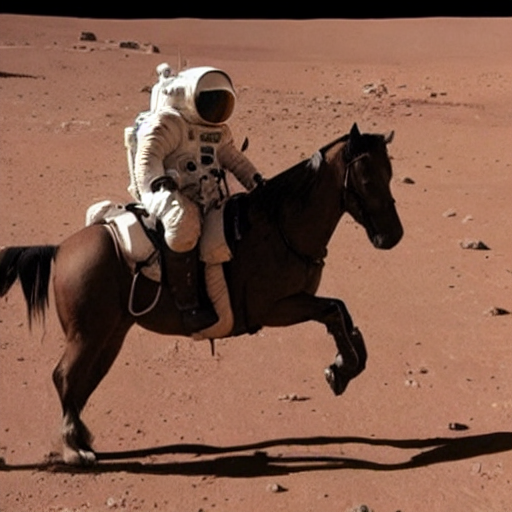

In [3]:
torch.manual_seed(1337)

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")
image

## Implementing the Pipeline

The goal of this notebook is to implement each component of the stable diffusion pipeline and dive deeper into each one as I progress through the [Practical Deep Learning for Coders: Part 2](https://course.fast.ai/Lessons/part2.html) course.

I will be checking mostly the [Hugging Face docs](https://huggingface.co/docs), the source code of each individual module, such as [the source code for the pipeline itself](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py) and the course material itself, especially the [Stable Diffusion Deep Dive](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) notebook.

TODO: Diagram of the stable diffusion pipeline.

Here are the parameters used for the generation of each image.

In [4]:
height = 512
width = 512
guidance_scale = 7.5
batch_size = 1
num_inference_steps = 50
scheduler = PNDMScheduler(num_train_timesteps=1000, beta_start=.00085,
                          beta_end=.012, beta_schedule='scaled_linear')

This is a simplified version of the [the denoising loop](https://github.com/huggingface/diffusers/blob/5802c2e3f27c6b45290773691bbece4091b69ddc/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L987) of the diffusers library:
```python
prompt_embeds = encode_prompt()
timesteps = retrieve_timesteps()
latents = prepare_latents()

with progress_bar(total=num_inference_steps) as progress_bar:
    for t in timesteps:
        # expand the latents if we are doing classifier free guidance
        latent_model_input = expand_latents()
        latent_model_input = scale_latents()

        # predict the noise residual
        noise_pred = predict_noise_unet()

        # perform guidance
        noise_pred_uncond, noise_pred_text = perform_guidance()

        # compute the previous noisy sample x_t -> x_t-1
        latents = step_scheduler()

image = decode_latents()

return image
```

### The Text Encoder

This component will take our prompt and turn it into valid inputs for the stable diffusion model. As output we will get an embedding of our desired prompt and an embedding of the unconditional prompt to be used in Classifier-Free Guidance later.

In [5]:
def print_shape(tensor):
  print('Shape: ', tensor.shape)

[from_pretrained()](https://huggingface.co/docs/transformers/v4.42.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.from_pretrained)

[tokenizer()](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)

In [6]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14',
                                          torch_dtype=torch.float16)
text_inputs = tokenizer(text=prompt, padding='max_length', truncation=True,
                        max_length=tokenizer.model_max_length,
                        return_tensors='pt')
tokenized_prompt = text_inputs.input_ids
print_shape(tokenized_prompt)
print(tokenized_prompt)

Shape:  torch.Size([1, 77])
tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525,
          7496, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])


Above we have our tokenised prompt. We take each word from our prompt and map it to a number (token). Note that we pad our prompt to be the correct size that the model expects, which is 77.

We can decode the tokenised prompt to get our prompt back.

[decode()](https://huggingface.co/docs/transformers/v4.42.0/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.decode)

In [7]:
print('input: ', prompt)
print('encoded output: ', tokenized_prompt)
print('decoded output: ', end='')
for id in tokenized_prompt:
  print(tokenizer.decode(id))

input:  a photo of an astronaut riding a horse on mars
encoded output:  tensor([[49406,   320,  1125,   539,   550, 18376,  6765,   320,  4558,   525,
          7496, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
decoded output: <|startoftext|>a photo of an astronaut riding a horse on mars <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|e

In [8]:
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',
                                             torch_dtype=torch.float16).to(device)
# text_encoder.config # Advanced information of the text model

[text_encoder()](https://huggingface.co/docs/transformers/en/model_doc/clip#transformers.CLIPTextModel.forward)

In [9]:
prompt_embeddings = text_encoder(tokenized_prompt.to(device=device))
prompt_embeddings = prompt_embeddings[0].to(dtype=torch.float16, device=device)
print_shape(prompt_embeddings)
print(prompt_embeddings)

Shape:  torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0297, -1.3242,  0.3076,  ..., -0.5234,  0.9746,  0.6650],
         [ 1.1553,  0.1337,  0.7881,  ..., -2.1035, -1.1514, -0.3293],
         ...,
         [-2.2598,  0.5674, -0.2505,  ..., -0.4871,  0.0539,  0.6323],
         [-2.2637,  0.5669, -0.2720,  ..., -0.4819,  0.0518,  0.6143],
         [-2.2246,  0.5776, -0.2729,  ..., -0.4248,  0.0713,  0.5938]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)


This is the embedding of our prompt required for the stable diffusion model. We mapped our tokens to a higher dimensional space, so for each token we get a tensor that is 768 elements long.

We can now define a function that automates the generation of the embeddings for any given prompt.

In [10]:
def prompt_to_embedding(prompt, tokenizer, text_encoder):
  text_inputs = tokenizer(text=prompt, padding='max_length', truncation=True,
                          max_length=tokenizer.model_max_length,
                          return_tensors='pt')
  tokenized_prompt = text_inputs.input_ids
  prompt_embeddings = text_encoder(tokenized_prompt.to(device))

  return prompt_embeddings[0].to(dtype=torch.float16, device=device)

Let's check if the unconditional prompt is mapped to a different embedding than our prompt.

In [11]:
unconditional_prompt = ''
unconditional_prompt_embeddings = prompt_to_embedding(unconditional_prompt, tokenizer, text_encoder)
print_shape(unconditional_prompt_embeddings)
print(unconditional_prompt_embeddings)

Shape:  torch.Size([1, 77, 768])
tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [-0.3711, -1.4502, -0.3406,  ...,  0.9468,  0.1860, -1.1035],
         [-0.5117, -1.4629, -0.2913,  ...,  1.0430,  0.0701, -1.0283],
         ...,
         [ 0.4995, -0.9570, -0.6602,  ...,  1.6006, -1.0625, -0.2196],
         [ 0.4985, -0.9473, -0.6680,  ...,  1.6465, -1.0869, -0.2092],
         [ 0.4915, -0.8145, -0.4915,  ...,  1.6104, -1.0176, -0.2477]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)


It is! Now we can define a function to get the inputs the model expects from our desired prompt.

In [12]:
def encode_prompt(prompt):
  tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14',
                                            torch_dtype=torch.float16)
  text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',
                                             torch_dtype=torch.float16).to('cuda')
  prompt_embeddings = prompt_to_embedding(prompt, tokenizer, text_encoder)
  unconditional_embeddings = prompt_to_embedding('', tokenizer, text_encoder)
  embeddings = torch.cat([unconditional_embeddings, prompt_embeddings])

  return embeddings

encode_prompt(prompt)

tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [-0.3711, -1.4502, -0.3406,  ...,  0.9468,  0.1860, -1.1035],
         [-0.5117, -1.4629, -0.2913,  ...,  1.0430,  0.0701, -1.0283],
         ...,
         [ 0.4995, -0.9570, -0.6602,  ...,  1.6006, -1.0625, -0.2196],
         [ 0.4985, -0.9473, -0.6680,  ...,  1.6465, -1.0869, -0.2092],
         [ 0.4915, -0.8145, -0.4915,  ...,  1.6104, -1.0176, -0.2477]],

        [[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0297, -1.3242,  0.3076,  ..., -0.5234,  0.9746,  0.6650],
         [ 1.1553,  0.1337,  0.7881,  ..., -2.1035, -1.1514, -0.3293],
         ...,
         [-2.2598,  0.5674, -0.2505,  ..., -0.4871,  0.0539,  0.6323],
         [-2.2637,  0.5669, -0.2720,  ..., -0.4819,  0.0518,  0.6143],
         [-2.2246,  0.5776, -0.2729,  ..., -0.4248,  0.0713,  0.5938]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<CatBackward0>)

### The Scheduler

This component determines the amount of noise to be added at each timestep.

The default scheduler for this diffusion model uses the following parameters:

In [13]:
pipe.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('skip_prk_steps', True),
            ('set_alpha_to_one', False),
            ('prediction_type', 'epsilon'),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 1),
            ('_use_default_values', ['prediction_type', 'timestep_spacing']),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.7.0.dev0'),
            ('clip_sample', False)])

In [14]:
scheduler.set_timesteps(num_inference_steps)

The formula for this scheduler's noise multiplier is the following, where t is the current timestep:

In [15]:
t = 999
(1 - scheduler.alphas_cumprod[[t]]) ** 0.5

tensor([0.9977])

We can make sure this is indeed the formula by comparing the output with the internal function of the scheduler.

In [16]:
# scheduler.add_noise?? # Uncomment this line to check its source code

In [17]:
for t in range(1000):
  assert torch.equal((1 - scheduler.alphas_cumprod[[t]]) ** 0.5,
                     scheduler.add_noise(torch.tensor(0.), torch.tensor(1.), torch.tensor(t))), 'Output does not match.'

In [18]:
scheduler.timesteps

tensor([980, 970, 970, 960, 960, 950, 950, 940, 940, 930, 930, 920, 920, 900,
        880, 860, 840, 820, 800, 780, 760, 740, 720, 700, 680, 660, 640, 620,
        600, 580, 560, 540, 520, 500, 480, 460, 440, 420, 400, 380, 360, 340,
        320, 300, 280, 260, 240, 220, 200, 180, 160, 140, 120, 100,  80,  60,
         40,  20,   0])

In [19]:
len(scheduler.timesteps) # this is equal to num_inference_steps + warmup rounds

59

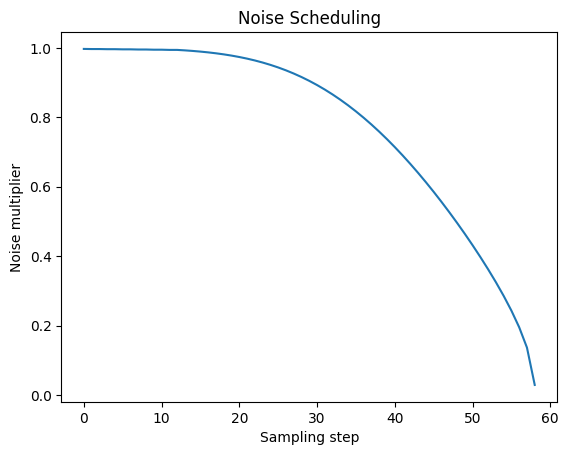

In [20]:
plt.plot([(1 - scheduler.alphas_cumprod[[t]]) ** 0.5 for t in scheduler.timesteps])
plt.title('Noise Scheduling')
plt.xlabel('Sampling step')
plt.ylabel('Noise multiplier')
plt.show()

In [21]:
def retrieve_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  return scheduler.timesteps

retrieve_timesteps(scheduler, num_inference_steps)

tensor([980, 970, 970, 960, 960, 950, 950, 940, 940, 930, 930, 920, 920, 900,
        880, 860, 840, 820, 800, 780, 760, 740, 720, 700, 680, 660, 640, 620,
        600, 580, 560, 540, 520, 500, 480, 460, 440, 420, 400, 380, 360, 340,
        320, 300, 280, 260, 240, 220, 200, 180, 160, 140, 120, 100,  80,  60,
         40,  20,   0])

### The Variational Autoencoder (VAE)

The VAE can encode images into the latent space and decode latents into images. This is useful because the latent representation of an image is a compressed version of itself, allowing us to save computational resources while performing the diffusion loop.

In [22]:
vae = AutoencoderKL.from_pretrained('CompVis/stable-diffusion-v1-4',
                                    subfolder='vae',
                                    torch_dtype=torch.float16).to('cuda')
vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 512),
            ('scaling_factor', 0.18215),
            ('shift_factor', None),
            ('latents_mean', None),
            ('latents_std', None),
            ('force_upcast', True),
            ('use_quant_conv', True),
            ('use_post_quant_conv', True),
            ('_use_default_values',
             ['use_post_quant_conv',
              '

Let's see how the encoding and decoding processes work.

This is the image we generated previously.

Image shape: (512, 512, 3)


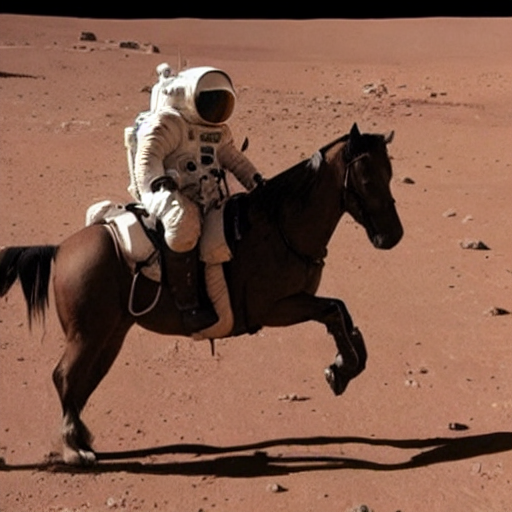

In [23]:
image = Image.open('astronaut_rides_horse.png').resize((512, 512))
print('Image shape:', np.asarray(image).shape)
image

In [24]:
image_tensor = transforms.ToTensor()(image).to(dtype=torch.float16,
                                               device='cuda')[None,:]
print('Tensor shape:', image_tensor.shape)

Tensor shape: torch.Size([1, 3, 512, 512])


Let's map our image into the latent space.

In [25]:
with torch.no_grad():
  latent = vae.config.scaling_factor * vae.encode(image_tensor*2-1).latent_dist.sample() # Why image*2-1?

In [26]:
vae.config.scaling_factor

0.18215

[Here](https://github.com/huggingface/diffusers/issues/437#issuecomment-1241827515) is an explanation of why the scaling factor 0.18215 is used here.

In [27]:
print('Latent shape:', latent.shape)

Latent shape: torch.Size([1, 4, 64, 64])


We can see that the tensor representing the image is far smaller in its latent representation.

In [28]:
print('Number of elements in image tensor:\t\t', torch.numel(image_tensor))
print('Number of elements in latent representation:\t', torch.numel(latent))
print(f'{torch.numel(image_tensor)/torch.numel(latent)}x compression')

Number of elements in image tensor:		 786432
Number of elements in latent representation:	 16384
48.0x compression


This is the content of each channel of the latents.

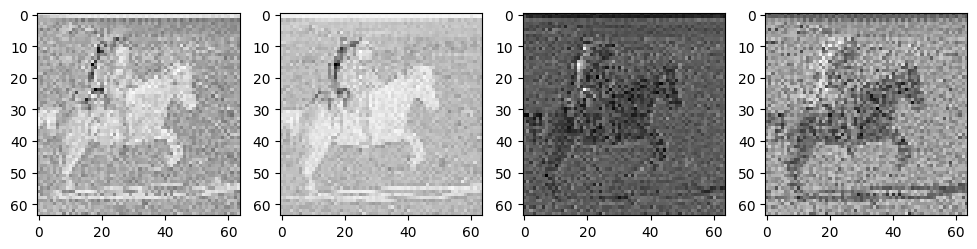

In [29]:
num_channels = latent.shape[1]
fig, axs = plt.subplots(1, num_channels, figsize=(3*num_channels, 3))
for c in range(num_channels):
  axs[c].imshow(latent[0][c].cpu(), cmap='Greys')

In [30]:
with torch.no_grad():
  decoded_image = vae.decode(1/vae.config.scaling_factor * latent).sample
decoded_image = ((decoded_image+1)/2).clamp(0, 1)
decoded_image = decoded_image[0].detach().cpu().permute(1, 2, 0).numpy()
decoded_image = (decoded_image*255).round().astype('uint8')
decoded_image.shape

(512, 512, 3)

Decoding this latent representation gets us an image that looks like the original input.

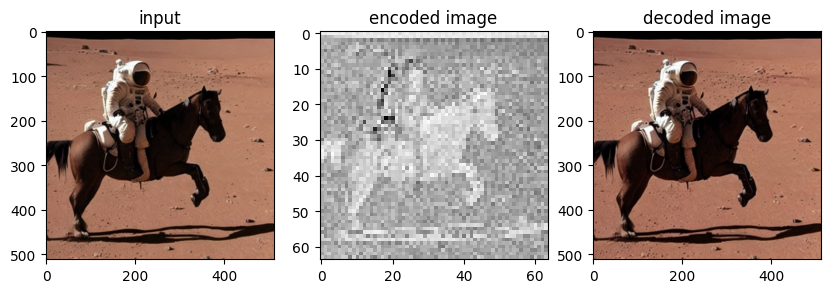

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('input')
axs[1].imshow(latent[0][0].cpu(), cmap='Greys')
axs[1].set_title('encoded image')
axs[2].imshow(decoded_image)
axs[2].set_title('decoded image')
plt.show()

By using a VAE, we can significantly improve the efficiency of the diffusion process. We can work with a representation of an image that is 48 times smaller than the target resolution, saving resources. After this, we simply decode this representation back into a high resolution image.

In [32]:
def decode_latents(latent, vae):
  with torch.no_grad():
    decoded_image = vae.decode(1/vae.config.scaling_factor * latent).sample
  decoded_image = ((decoded_image+1)/2).clamp(0, 1)
  decoded_image = decoded_image[0].detach().cpu().permute(1, 2, 0).numpy()
  decoded_image = (decoded_image*255).round().astype('uint8')

  return decoded_image

### The U-Net

In [33]:
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4',
                                            subfolder='unet', torch_dtype=torch.float16,
                                            low_cpu_mem_usage=False).to('cuda')

### The Latents

A latent is the image after it has been compressed by the VAE.

In [34]:
def prepare_latents(height, width, scheduler, vae, unet):
  vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
  shape = (1, unet.config.in_channels, height // vae_scale_factor,
           width // vae_scale_factor)
  latents = torch.randn(shape)
  return latents.to(device='cuda', dtype=torch.float16) * scheduler.init_noise_sigma

latents = prepare_latents(height, width, scheduler, vae, unet)
print_shape(latents)
latents

Shape:  torch.Size([1, 4, 64, 64])


tensor([[[[ 0.2917, -0.6309,  1.5049,  ...,  1.0342,  0.8818,  0.4009],
          [-2.8535,  0.3311,  0.9341,  ..., -0.1207,  1.3574,  0.5391],
          [ 0.0874,  0.3169,  1.1025,  ...,  1.2422, -0.2426, -1.4609],
          ...,
          [ 0.8496,  0.7842, -0.4153,  ...,  1.6895,  0.2771,  0.2360],
          [ 0.0792,  0.0869, -0.9395,  ..., -0.0413,  0.4265, -0.7417],
          [-0.5605, -0.1763, -2.1816,  ..., -0.4016,  0.4421, -0.0654]],

         [[-0.5713,  1.6484,  1.4316,  ..., -1.6357, -0.9385, -1.6016],
          [-0.6685, -0.9272, -0.9624,  ...,  0.5947, -0.9258, -0.5986],
          [ 0.0669, -1.3096, -0.1379,  ...,  1.4189,  0.5298,  0.6255],
          ...,
          [-1.2627, -0.8594,  0.4409,  ...,  0.0443,  1.5059, -1.0088],
          [-1.7129,  0.0334,  0.3711,  ...,  1.0889, -0.1179,  0.0640],
          [-3.4180, -0.3774,  0.5459,  ...,  0.5229, -0.3765,  1.0225]],

         [[-0.8428,  1.3643,  1.0830,  ...,  0.4331, -0.4199, -0.5029],
          [-1.8311,  1.1074, -

We will need two copies of the latents for Classifier-Free Guidance.

In [35]:
def expand_latents(latents):
  return torch.cat([latents] * 2)

expand_latents(latents)

tensor([[[[ 0.2917, -0.6309,  1.5049,  ...,  1.0342,  0.8818,  0.4009],
          [-2.8535,  0.3311,  0.9341,  ..., -0.1207,  1.3574,  0.5391],
          [ 0.0874,  0.3169,  1.1025,  ...,  1.2422, -0.2426, -1.4609],
          ...,
          [ 0.8496,  0.7842, -0.4153,  ...,  1.6895,  0.2771,  0.2360],
          [ 0.0792,  0.0869, -0.9395,  ..., -0.0413,  0.4265, -0.7417],
          [-0.5605, -0.1763, -2.1816,  ..., -0.4016,  0.4421, -0.0654]],

         [[-0.5713,  1.6484,  1.4316,  ..., -1.6357, -0.9385, -1.6016],
          [-0.6685, -0.9272, -0.9624,  ...,  0.5947, -0.9258, -0.5986],
          [ 0.0669, -1.3096, -0.1379,  ...,  1.4189,  0.5298,  0.6255],
          ...,
          [-1.2627, -0.8594,  0.4409,  ...,  0.0443,  1.5059, -1.0088],
          [-1.7129,  0.0334,  0.3711,  ...,  1.0889, -0.1179,  0.0640],
          [-3.4180, -0.3774,  0.5459,  ...,  0.5229, -0.3765,  1.0225]],

         [[-0.8428,  1.3643,  1.0830,  ...,  0.4331, -0.4199, -0.5029],
          [-1.8311,  1.1074, -

In [36]:
def scale_latents(latents, scheduler, t):
  return scheduler.scale_model_input(latents, t)

### The Diffusion Loop

  0%|          | 0/59 [00:00<?, ?it/s]

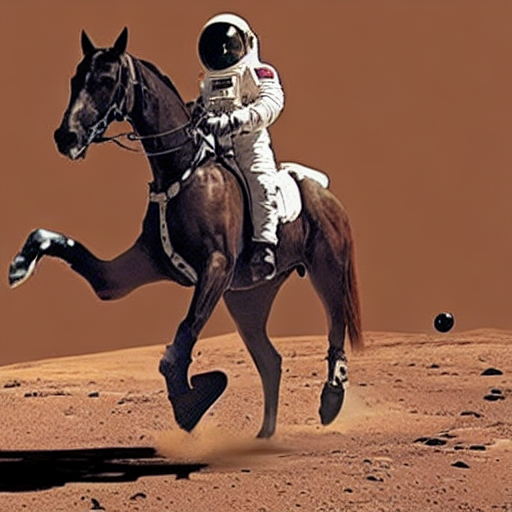

In [37]:
torch.manual_seed(1337)

prompt_embeds = encode_prompt(prompt)
timesteps = retrieve_timesteps(scheduler, num_inference_steps)
latents = prepare_latents(height, width, scheduler, vae, unet)

for t in tqdm(timesteps):
  latent_model_input = expand_latents(latents)
  latent_model_input = scale_latents(latent_model_input, scheduler, t)

  with torch.no_grad():
    pred = unet(latent_model_input, t, encoder_hidden_states=prompt_embeds).sample

  pred_uncond, pred_text = pred.chunk(2)
  pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

  latents = scheduler.step(pred, t, latents).prev_sample

Image.fromarray(decode_latents(latents, vae))

## Entire Code in a Cell

In [38]:
device = 'cuda'
scheduler = PNDMScheduler(num_train_timesteps=1000, beta_start=.00085,
                          beta_end=.012, beta_schedule='scaled_linear')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',
                                             torch_dtype=torch.float16).to(device)

def prompt_to_embedding(prompt, tokenizer, text_encoder):
  text_inputs = tokenizer(text=prompt, padding='max_length', truncation=True,
                          max_length=tokenizer.model_max_length,
                          return_tensors='pt')
  tokenized_prompt = text_inputs.input_ids
  prompt_embeddings = text_encoder(tokenized_prompt.to(device))

  return prompt_embeddings[0].to(dtype=torch.float16, device=device)

def encode_prompt(prompt):
  tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14',
                                            torch_dtype=torch.float16)
  text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14',
                                             torch_dtype=torch.float16).to('cuda')
  prompt_embeddings = prompt_to_embedding(prompt, tokenizer, text_encoder)
  unconditional_embeddings = prompt_to_embedding('', tokenizer, text_encoder)
  embeddings = torch.cat([unconditional_embeddings, prompt_embeddings])

  return embeddings

def retrieve_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  return scheduler.timesteps

vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema',
                                    torch_dtype=torch.float16).to('cuda')

def decode_latents(latent, vae):
  with torch.no_grad():
    decoded_image = vae.decode(1/vae.config.scaling_factor * latent).sample
  decoded_image = ((decoded_image+1)/2).clamp(0, 1)
  decoded_image = decoded_image[0].detach().cpu().permute(1, 2, 0).numpy()
  decoded_image = (decoded_image*255).round().astype('uint8')

  return decoded_image

unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4',
                                            subfolder='unet', torch_dtype=torch.float16,
                                            low_cpu_mem_usage=False).to('cuda')

def prepare_latents(height, width, scheduler, vae, unet):
  vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
  shape = (1, unet.config.in_channels, height // vae_scale_factor,
           width // vae_scale_factor)
  latents = torch.randn(shape)
  return latents.to(device='cuda', dtype=torch.float16) * scheduler.init_noise_sigma

def expand_latents(latents):
  return torch.cat([latents] * 2)

def scale_latents(latents, scheduler, t):
  return scheduler.scale_model_input(latents, t)

  0%|          | 0/59 [00:00<?, ?it/s]

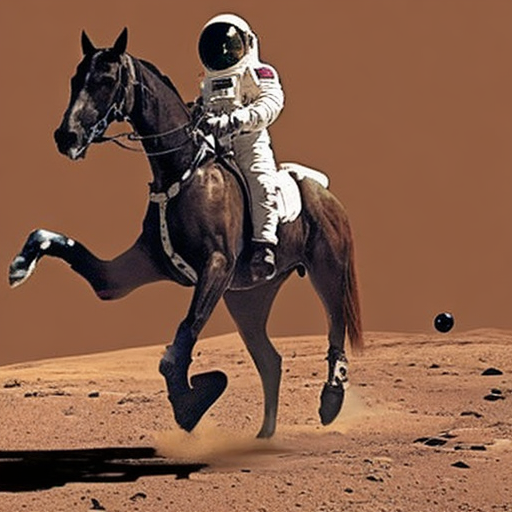

In [39]:
torch.manual_seed(1337)
prompt = 'a photo of an astronaut riding a horse on mars'
height = 512
width = 512
guidance_scale = 7.5
batch_size = 1
num_inference_steps = 50
prompt_embeds = encode_prompt(prompt)
timesteps = retrieve_timesteps(scheduler, num_inference_steps)
latents = prepare_latents(height, width, scheduler, vae, unet)

for t in tqdm(timesteps):
  latent_model_input = expand_latents(latents)
  latent_model_input = scale_latents(latent_model_input, scheduler, t)

  with torch.no_grad():
    pred = unet(latent_model_input, t, encoder_hidden_states=prompt_embeds).sample

  pred_uncond, pred_text = pred.chunk(2)
  pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

  latents = scheduler.step(pred, t, latents).prev_sample

Image.fromarray(decode_latents(latents, vae))